🔄 Convirtiendo fechas...
✅ Fechas convertidas correctamente
📊 Creando serie temporal de citas...
   - Registros totales: 212
   - Período: 2025-01-01 00:00:00 a 2025-07-31 00:00:00
   - Promedio diario: 47.2 citas
   - Datos de entrenamiento: 169 días
   - Datos de prueba: 43 días
🤖 Entrenando modelo ARIMA...


c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


📈 Entrenando modelo Holt-Winters...
📊 Calculando métricas...

=== FORECASTING DE CITAS POR DÍA ===

�� MÉTRICAS ARIMA:
   MSE: 40.853
   RMSE: 6.392
   MAE: 5.138
   MAPE: 12.184
   SMAPE: 11.359
   R2: -0.102
   THEIL_U: 0.068

📈 MÉTRICAS HOLT-WINTERS:
   MSE: 42.787
   RMSE: 6.541
   MAE: 5.266
   MAPE: 12.558
   SMAPE: 11.627
   R2: -0.154
   THEIL_U: 0.070

🏆 MEJOR MODELO: ARIMA (RMSE: 6.392)

🎨 Generando visualización...
💾 Gráfica guardada como 'citas_forecasting.png'


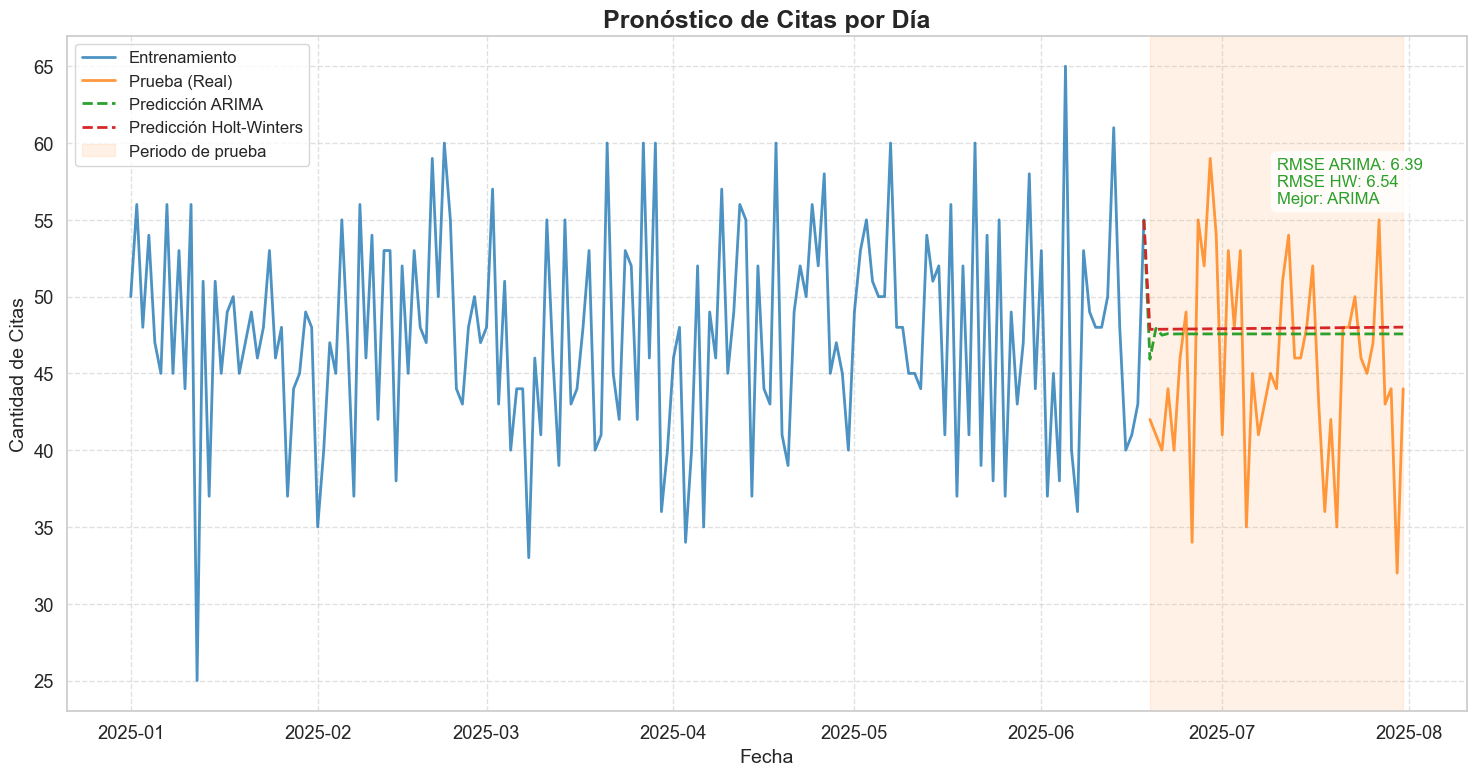


�� ANÁLISIS ADICIONAL:

�� ESTADÍSTICAS DE LA SERIE TEMPORAL:
   - Media: 47.17 citas/día
   - Mediana: 47.00 citas/día
   - Desviación estándar: 6.69
   - Mínimo: 25 citas
   - Máximo: 65 citas

📈 TENDENCIA:
   - Tendencia: Disminuyendo

🎯 PREDICCIÓN:
   - Próximos 43 días: 47.5 citas/día (ARIMA)
   - Próximos 43 días: 47.9 citas/día (Holt-Winters)


In [2]:
import pandas as pd
import os

# Importar modelos y métricas
from src.core.base_model import ARIMAModel, HoltWintersModel
from src.core.metrics import TimeSeriesMetrics

# 1. Cargar los datos limpios con manejo correcto de fechas
ruta_data = '.'  # Ajusta si tus archivos están en otra carpeta

# Cargar datos sin parse_dates para manejar manualmente las fechas
appointments = pd.read_csv(os.path.join(ruta_data, 'appointments_clean.csv'))
ai_clean = pd.read_csv(os.path.join(ruta_data, 'ai_clean.csv'))
tasks_clean = pd.read_csv(os.path.join(ruta_data, 'tasks_clean.csv'))

# Convertir fechas con manejo de zona horaria
print("🔄 Convirtiendo fechas...")

# Para appointments
if 'fecha_cita' in appointments.columns:
    appointments['fecha_cita'] = pd.to_datetime(appointments['fecha_cita'], format='mixed', utc=True)
if 'created_at' in appointments.columns:
    appointments['created_at'] = pd.to_datetime(appointments['created_at'], format='mixed', utc=True)
if 'updated_at' in appointments.columns:
    appointments['updated_at'] = pd.to_datetime(appointments['updated_at'], format='mixed', utc=True)

# Para ai_clean
if 'created_at' in ai_clean.columns:
    ai_clean['created_at'] = pd.to_datetime(ai_clean['created_at'], format='mixed', utc=True)

# Para tasks_clean
if 'fecha_cita' in tasks_clean.columns:
    tasks_clean['fecha_cita'] = pd.to_datetime(tasks_clean['fecha_cita'], format='mixed', utc=True)

print("✅ Fechas convertidas correctamente")

# 2. Crear la serie temporal: cantidad de citas por día
print("📊 Creando serie temporal de citas...")
appointments_daily = appointments.groupby(appointments['fecha_cita'].dt.date).size()
appointments_daily.index = pd.to_datetime(appointments_daily.index)
appointments_daily = appointments_daily.sort_index()

print(f"   - Registros totales: {len(appointments_daily)}")
print(f"   - Período: {appointments_daily.index.min()} a {appointments_daily.index.max()}")
print(f"   - Promedio diario: {appointments_daily.mean():.1f} citas")

# 3. Separar train/test (por ejemplo, 80% train, 20% test)
split_idx = int(len(appointments_daily) * 0.8)
train, test = appointments_daily.iloc[:split_idx], appointments_daily.iloc[split_idx:]

print(f"   - Datos de entrenamiento: {len(train)} días")
print(f"   - Datos de prueba: {len(test)} días")

# 4. Entrenar modelo ARIMA
print("🤖 Entrenando modelo ARIMA...")
arima_model = ARIMAModel(order=(1,1,1))
arima_model.fit(train)
arima_pred = arima_model.predict(len(test))
arima_pred.index = test.index  # Alinear índices

# 5. Entrenar modelo Holt-Winters
print("📈 Entrenando modelo Holt-Winters...")
hw_model = HoltWintersModel(seasonal_periods=7, trend='add', seasonal=None, damped_trend=False)
hw_model.fit(train)
hw_pred = hw_model.predict(len(test))
hw_pred.index = test.index  # Alinear índices

# 6. Calcular métricas de forecasting
print("📊 Calculando métricas...")
arima_metrics = TimeSeriesMetrics.calculate_forecast_accuracy(test, arima_pred)
hw_metrics = TimeSeriesMetrics.calculate_forecast_accuracy(test, hw_pred)

print("\n" + "="*50)
print("=== FORECASTING DE CITAS POR DÍA ===")
print("="*50)

print("\n�� MÉTRICAS ARIMA:")
for k, v in arima_metrics.items():
    print(f"   {k.upper()}: {v:.3f}")

print("\n📈 MÉTRICAS HOLT-WINTERS:")
for k, v in hw_metrics.items():
    print(f"   {k.upper()}: {v:.3f}")

# Determinar mejor modelo
if arima_metrics['rmse'] < hw_metrics['rmse']:
    mejor_modelo = "ARIMA"
    mejor_rmse = arima_metrics['rmse']
else:
    mejor_modelo = "Holt-Winters"
    mejor_rmse = hw_metrics['rmse']

print(f"\n🏆 MEJOR MODELO: {mejor_modelo} (RMSE: {mejor_rmse:.3f})")

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

print("\n🎨 Generando visualización...")

# Concatenar el último valor real de entrenamiento con la predicción para continuidad visual
arima_pred_full = pd.concat([train[-1:], arima_pred])
arima_pred_full.index = train[-1:].index.append(arima_pred.index)

hw_pred_full = pd.concat([train[-1:], hw_pred])
hw_pred_full.index = train[-1:].index.append(hw_pred.index)

# Configurar estilo
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(15, 8))

# Plotear datos
plt.plot(train.index, train, label='Entrenamiento', color='#1f77b4', linewidth=2, alpha=0.8)
plt.plot(test.index, test, label='Prueba (Real)', color='#ff7f0e', linewidth=2, alpha=0.8)
plt.plot(arima_pred_full.index, arima_pred_full, label='Predicción ARIMA', color='#2ca02c', linestyle='--', linewidth=2)
plt.plot(hw_pred_full.index, hw_pred_full, label='Predicción Holt-Winters', color='#d62728', linestyle='--', linewidth=2)

# Área de prueba
plt.axvspan(test.index[0], test.index[-1], color='#ff7f0e', alpha=0.1, label='Periodo de prueba')

# Configurar gráfica
plt.title('Pronóstico de Citas por Día', fontsize=18, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad de Citas', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Agregar métricas en la gráfica
max_val = max(test.max(), arima_pred_full.max(), hw_pred_full.max())
plt.text(test.index[int(len(test)/2)], max_val * 0.95, 
         f"RMSE ARIMA: {arima_metrics['rmse']:.2f}\nRMSE HW: {hw_metrics['rmse']:.2f}\nMejor: {mejor_modelo}", 
         fontsize=12, color='#2ca02c', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

# Guardar gráfica
plt.savefig('citas_forecasting.png', dpi=300, bbox_inches='tight')
print("💾 Gráfica guardada como 'citas_forecasting.png'")

plt.show()

# Análisis adicional
print("\n�� ANÁLISIS ADICIONAL:")
print("="*30)

print(f"\n�� ESTADÍSTICAS DE LA SERIE TEMPORAL:")
print(f"   - Media: {appointments_daily.mean():.2f} citas/día")
print(f"   - Mediana: {appointments_daily.median():.2f} citas/día")
print(f"   - Desviación estándar: {appointments_daily.std():.2f}")
print(f"   - Mínimo: {appointments_daily.min()} citas")
print(f"   - Máximo: {appointments_daily.max()} citas")

print(f"\n📈 TENDENCIA:")
if appointments_daily.iloc[-10:].mean() > appointments_daily.iloc[:10].mean():
    print("   - Tendencia: Aumentando")
else:
    print("   - Tendencia: Disminuyendo")

print(f"\n🎯 PREDICCIÓN:")
print(f"   - Próximos {len(test)} días: {arima_pred.mean():.1f} citas/día (ARIMA)")
print(f"   - Próximos {len(test)} días: {hw_pred.mean():.1f} citas/día (Holt-Winters)")

�� Calculando tasa de asistencia diaria...
   - Registros totales: 212 días
   - Período: 2025-01-01 00:00:00 a 2025-07-31 00:00:00
   - Tasa promedio de asistencia: 29.7%
   - Datos de entrenamiento: 169 días
   - Datos de prueba: 43 días
🤖 Entrenando modelo ARIMA...
📈 Entrenando modelo Holt-Winters...

=== FORECASTING DE TASA DE ASISTENCIA DIARIA ===

�� MÉTRICAS ARIMA:
   MSE: 0.004
   RMSE: 0.066
   MAE: 0.053
   MAPE: 18.947
   SMAPE: 18.024
   R2: -0.037
   THEIL_U: 0.108

📈 MÉTRICAS HOLT-WINTERS:
   MSE: 0.004
   RMSE: 0.065
   MAE: 0.052
   MAPE: 18.728
   SMAPE: 17.452
   R2: -0.004
   THEIL_U: 0.105

🏆 MEJOR MODELO: Holt-Winters (RMSE: 0.065)

🎨 Generando visualización...


c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


💾 Gráfica guardada como 'asistencia_forecasting.png'


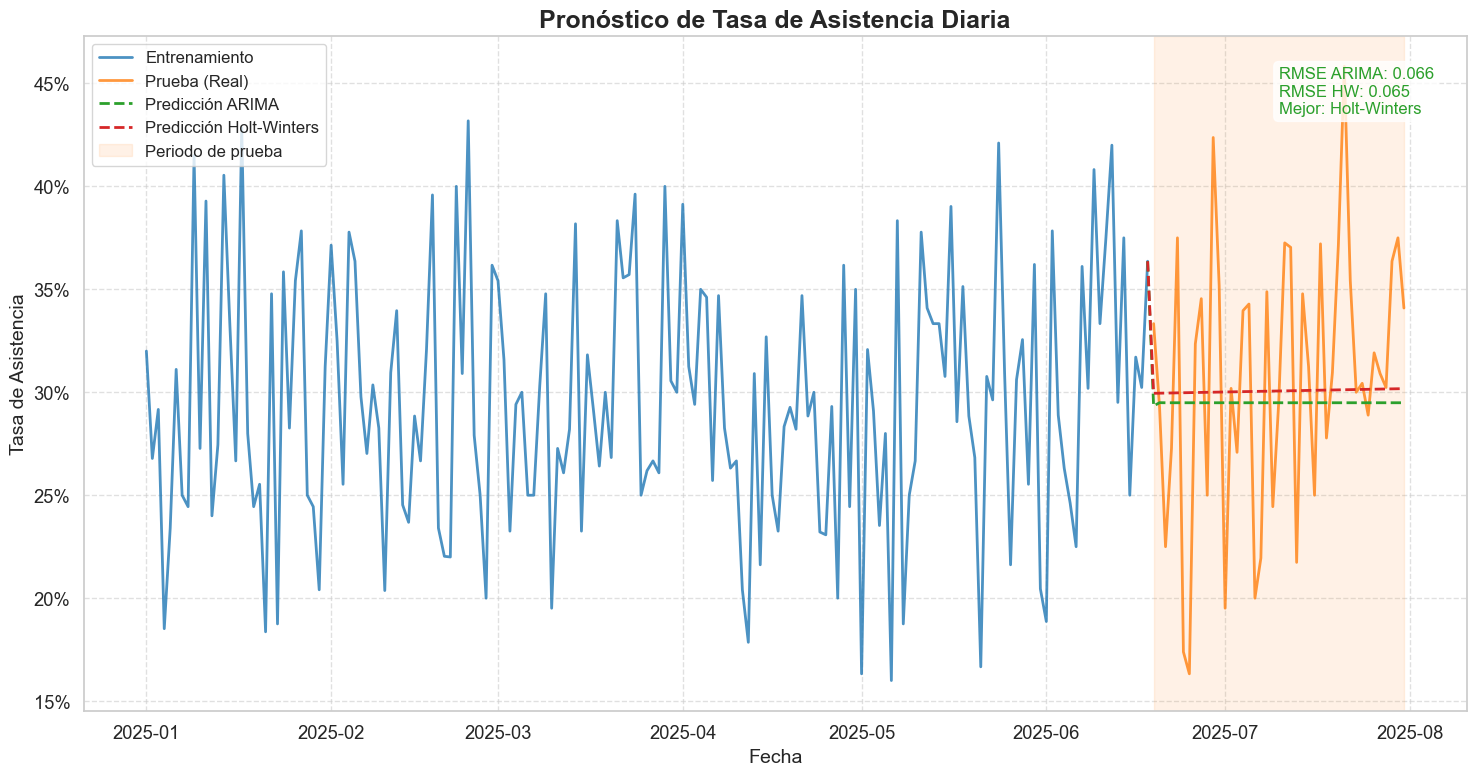


�� ANÁLISIS ADICIONAL:

�� ESTADÍSTICAS DE ASISTENCIA:
   - Tasa promedio: 29.7%
   - Mediana: 29.6%
   - Desviación estándar: 6.3%
   - Mínimo: 16.0%
   - Máximo: 45.8%

📅 ANÁLISIS POR ESTADO DE CITA:
   - confirmada: 3002 citas (30.0%)
   - completada: 2975 citas (29.8%)
   - pendiente: 1999 citas (20.0%)
   - cancelada: 1016 citas (10.2%)
   - no_asistio: 1008 citas (10.1%)

�� TENDENCIA DE ASISTENCIA:
   - Tendencia: Mejorando

🎯 PREDICCIÓN DE ASISTENCIA:
   - Próximos 43 días: 29.5% (ARIMA)
   - Próximos 43 días: 30.1% (Holt-Winters)

📅 ANÁLISIS POR DÍA DE LA SEMANA:
   - Lunes: 31.5%
   - Martes: 29.2%
   - Miércoles: 29.4%
   - Jueves: 27.3%
   - Viernes: 30.8%
   - Sábado: 30.9%
   - Domingo: 29.3%
   - Mejor día: Lunes (31.5%)
   - Peor día: Jueves (27.3%)


In [3]:
# Calcular tasa de asistencia diaria
print("�� Calculando tasa de asistencia diaria...")

# Crear variable de asistencia
appointments['asistio'] = appointments['estado_cita'] == 'completada'
asistencia_diaria = appointments.groupby(appointments['fecha_cita'].dt.date)['asistio'].mean()
asistencia_diaria.index = pd.to_datetime(asistencia_diaria.index)
asistencia_diaria = asistencia_diaria.sort_index()

print(f"   - Registros totales: {len(asistencia_diaria)} días")
print(f"   - Período: {asistencia_diaria.index.min()} a {asistencia_diaria.index.max()}")
print(f"   - Tasa promedio de asistencia: {asistencia_diaria.mean():.1%}")

# Separar train/test
split_idx = int(len(asistencia_diaria) * 0.8)
train, test = asistencia_diaria.iloc[:split_idx], asistencia_diaria.iloc[split_idx:]

print(f"   - Datos de entrenamiento: {len(train)} días")
print(f"   - Datos de prueba: {len(test)} días")

# ARIMA
print("🤖 Entrenando modelo ARIMA...")
arima_model = ARIMAModel(order=(1,1,1))
arima_model.fit(train)
arima_pred = arima_model.predict(len(test))
arima_pred.index = test.index

# Holt-Winters
print("📈 Entrenando modelo Holt-Winters...")
hw_model = HoltWintersModel(seasonal_periods=7, trend='add', seasonal=None)
hw_model.fit(train)
hw_pred = hw_model.predict(len(test))
hw_pred.index = test.index

# Concatenar el último valor real de entrenamiento con la predicción
arima_pred_full = pd.concat([train[-1:], arima_pred])
arima_pred_full.index = train[-1:].index.append(arima_pred.index)

hw_pred_full = pd.concat([train[-1:], hw_pred])
hw_pred_full.index = train[-1:].index.append(hw_pred.index)

# Métricas
from src.core.metrics import TimeSeriesMetrics
arima_metrics = TimeSeriesMetrics.calculate_forecast_accuracy(test, arima_pred)
hw_metrics = TimeSeriesMetrics.calculate_forecast_accuracy(test, hw_pred)

print("\n" + "="*50)
print("=== FORECASTING DE TASA DE ASISTENCIA DIARIA ===")
print("="*50)

print("\n�� MÉTRICAS ARIMA:")
for k, v in arima_metrics.items():
    print(f"   {k.upper()}: {v:.3f}")

print("\n📈 MÉTRICAS HOLT-WINTERS:")
for k, v in hw_metrics.items():
    print(f"   {k.upper()}: {v:.3f}")

# Determinar mejor modelo
if arima_metrics['rmse'] < hw_metrics['rmse']:
    mejor_modelo = "ARIMA"
    mejor_rmse = arima_metrics['rmse']
else:
    mejor_modelo = "Holt-Winters"
    mejor_rmse = hw_metrics['rmse']

print(f"\n🏆 MEJOR MODELO: {mejor_modelo} (RMSE: {mejor_rmse:.3f})")

# Gráfica mejorada
import matplotlib.pyplot as plt
import seaborn as sns

print("\n🎨 Generando visualización...")

# Configurar estilo
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(15, 8))

# Plotear datos
plt.plot(train.index, train, label='Entrenamiento', color='#1f77b4', linewidth=2, alpha=0.8)
plt.plot(test.index, test, label='Prueba (Real)', color='#ff7f0e', linewidth=2, alpha=0.8)
plt.plot(arima_pred_full.index, arima_pred_full, label='Predicción ARIMA', color='#2ca02c', linestyle='--', linewidth=2)
plt.plot(hw_pred_full.index, hw_pred_full, label='Predicción Holt-Winters', color='#d62728', linestyle='--', linewidth=2)

# Área de prueba
plt.axvspan(test.index[0], test.index[-1], color='#ff7f0e', alpha=0.1, label='Periodo de prueba')

# Configurar gráfica
plt.title('Pronóstico de Tasa de Asistencia Diaria', fontsize=18, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Tasa de Asistencia', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Formatear eje Y como porcentaje
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Agregar métricas en la gráfica
max_val = max(test.max(), arima_pred_full.max(), hw_pred_full.max())
plt.text(test.index[int(len(test)/2)], max_val * 0.95, 
         f"RMSE ARIMA: {arima_metrics['rmse']:.3f}\nRMSE HW: {hw_metrics['rmse']:.3f}\nMejor: {mejor_modelo}", 
         fontsize=12, color='#2ca02c', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

# Guardar gráfica
plt.savefig('asistencia_forecasting.png', dpi=300, bbox_inches='tight')
print("💾 Gráfica guardada como 'asistencia_forecasting.png'")

plt.show()

# Análisis adicional
print("\n�� ANÁLISIS ADICIONAL:")
print("="*30)

print(f"\n�� ESTADÍSTICAS DE ASISTENCIA:")
print(f"   - Tasa promedio: {asistencia_diaria.mean():.1%}")
print(f"   - Mediana: {asistencia_diaria.median():.1%}")
print(f"   - Desviación estándar: {asistencia_diaria.std():.1%}")
print(f"   - Mínimo: {asistencia_diaria.min():.1%}")
print(f"   - Máximo: {asistencia_diaria.max():.1%}")

print(f"\n📅 ANÁLISIS POR ESTADO DE CITA:")
estado_counts = appointments['estado_cita'].value_counts()
total_citas = len(appointments)
for estado, count in estado_counts.items():
    porcentaje = (count / total_citas) * 100
    print(f"   - {estado}: {count} citas ({porcentaje:.1f}%)")

print(f"\n�� TENDENCIA DE ASISTENCIA:")
if asistencia_diaria.iloc[-10:].mean() > asistencia_diaria.iloc[:10].mean():
    print("   - Tendencia: Mejorando")
else:
    print("   - Tendencia: Deteriorándose")

print(f"\n🎯 PREDICCIÓN DE ASISTENCIA:")
print(f"   - Próximos {len(test)} días: {arima_pred.mean():.1%} (ARIMA)")
print(f"   - Próximos {len(test)} días: {hw_pred.mean():.1%} (Holt-Winters)")

# Análisis de días de la semana
print(f"\n📅 ANÁLISIS POR DÍA DE LA SEMANA:")
appointments['day_of_week'] = appointments['fecha_cita'].dt.dayofweek
asistencia_por_dia = appointments.groupby('day_of_week')['asistio'].mean()
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

for i, (dia, tasa) in enumerate(zip(dias, asistencia_por_dia)):
    print(f"   - {dia}: {tasa:.1%}")

mejor_dia = dias[asistencia_por_dia.idxmax()]
peor_dia = dias[asistencia_por_dia.idxmin()]
print(f"   - Mejor día: {mejor_dia} ({asistencia_por_dia.max():.1%})")
print(f"   - Peor día: {peor_dia} ({asistencia_por_dia.min():.1%})")

📋 Calculando tareas completadas por día...
   - Registros totales: 212 días
   - Período: 2025-01-01 00:00:00 a 2025-07-31 00:00:00
   - Promedio diario: 46.9 tareas completadas
   - Total de tareas completadas: 9952
   - Datos de entrenamiento: 169 días
   - Datos de prueba: 43 días
🤖 Entrenando modelo ARIMA...
📈 Entrenando modelo Holt-Winters...

=== FORECASTING DE TAREAS COMPLETADAS POR DÍA ===

 MÉTRICAS ARIMA:
   MSE: 95.271
   RMSE: 9.761
   MAE: 7.917
   MAPE: 19.111
   SMAPE: 17.300
   R2: -0.067
   THEIL_U: 0.103

📈 MÉTRICAS HOLT-WINTERS:
   MSE: 105.279
   RMSE: 10.261
   MAE: 8.556
   MAPE: 21.087
   SMAPE: 18.576
   R2: -0.179
   THEIL_U: 0.106

🏆 MEJOR MODELO: ARIMA (RMSE: 9.761)

🎨 Generando visualización...


c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


💾 Gráfica guardada como 'tareas_completadas_forecasting.png'


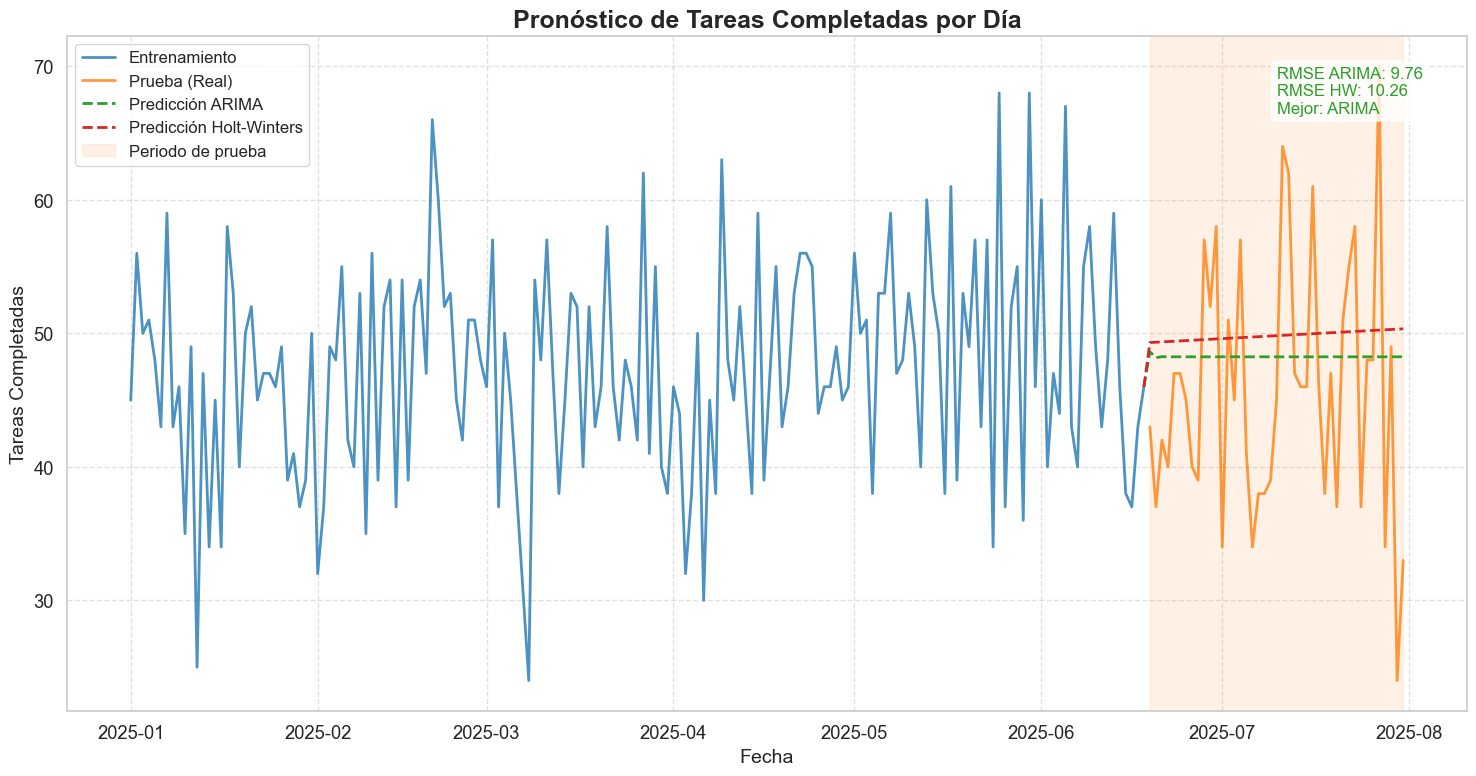


 ANÁLISIS ADICIONAL:

📊 ESTADÍSTICAS DE TAREAS:
   - Total de tareas: 20024
   - Tareas completadas: 9952
   - Tasa de completado: 49.7%
   - Promedio diario: 46.9 tareas
   - Mediana diaria: 47.0 tareas
   - Desviación estándar: 8.5
   - Mínimo diario: 24 tareas
   - Máximo diario: 70 tareas

📅 ANÁLISIS POR ESTADO DE CITA:
   - cancelada: 989.0 completadas de 2000.0 tareas (49.4%)
   - completada: 2933.0 completadas de 5967.0 tareas (49.2%)
   - confirmada: 2998.0 completadas de 6015.0 tareas (49.8%)
   - no_asistio: 984.0 completadas de 2006.0 tareas (49.1%)
   - pendiente: 2048.0 completadas de 4036.0 tareas (50.7%)

📈 TENDENCIA DE COMPLETADO:
   - Tendencia: Deteriorándose

 PREDICCIÓN DE TAREAS:
   - Próximos 43 días: 48.2 tareas/día (ARIMA)
   - Próximos 43 días: 49.8 tareas/día (Holt-Winters)

📅 ANÁLISIS POR DÍA DE LA SEMANA:
   - Lunes: 1369 completadas de 2737 tareas (50.0%)
   - Martes: 1440 completadas de 2854 tareas (50.5%)
   - Miércoles: 1480 completadas de 2987 tareas (

In [7]:
# Calcular tareas completadas por día
print("📋 Calculando tareas completadas por día...")

# Crear variable de tareas completadas
tasks_clean['tarea_completada'] = tasks_clean['task_completed']
tareas_completadas_diario = tasks_clean.groupby(tasks_clean['fecha_cita'].dt.date)['tarea_completada'].sum()
tareas_completadas_diario.index = pd.to_datetime(tareas_completadas_diario.index)
tareas_completadas_diario = tareas_completadas_diario.sort_index()

print(f"   - Registros totales: {len(tareas_completadas_diario)} días")
print(f"   - Período: {tareas_completadas_diario.index.min()} a {tareas_completadas_diario.index.max()}")
print(f"   - Promedio diario: {tareas_completadas_diario.mean():.1f} tareas completadas")
print(f"   - Total de tareas completadas: {tareas_completadas_diario.sum()}")

# Separar train/test
split_idx = int(len(tareas_completadas_diario) * 0.8)
train, test = tareas_completadas_diario.iloc[:split_idx], tareas_completadas_diario.iloc[split_idx:]

print(f"   - Datos de entrenamiento: {len(train)} días")
print(f"   - Datos de prueba: {len(test)} días")

# ARIMA
print("🤖 Entrenando modelo ARIMA...")
arima_model = ARIMAModel(order=(1,1,1))
arima_model.fit(train)
arima_pred = arima_model.predict(len(test))
arima_pred.index = test.index

# Holt-Winters
print("📈 Entrenando modelo Holt-Winters...")
hw_model = HoltWintersModel(seasonal_periods=7, trend='add', seasonal=None)
hw_model.fit(train)
hw_pred = hw_model.predict(len(test))
hw_pred.index = test.index

# Métricas
from src.core.metrics import TimeSeriesMetrics
arima_metrics = TimeSeriesMetrics.calculate_forecast_accuracy(test, arima_pred)
hw_metrics = TimeSeriesMetrics.calculate_forecast_accuracy(test, hw_pred)

print("\n" + "="*50)
print("=== FORECASTING DE TAREAS COMPLETADAS POR DÍA ===")
print("="*50)

print("\n MÉTRICAS ARIMA:")
for k, v in arima_metrics.items():
    print(f"   {k.upper()}: {v:.3f}")

print("\n📈 MÉTRICAS HOLT-WINTERS:")
for k, v in hw_metrics.items():
    print(f"   {k.upper()}: {v:.3f}")

# Determinar mejor modelo
if arima_metrics['rmse'] < hw_metrics['rmse']:
    mejor_modelo = "ARIMA"
    mejor_rmse = arima_metrics['rmse']
else:
    mejor_modelo = "Holt-Winters"
    mejor_rmse = hw_metrics['rmse']

print(f"\n🏆 MEJOR MODELO: {mejor_modelo} (RMSE: {mejor_rmse:.3f})")

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

print("\n🎨 Generando visualización...")

# Concatenar el último valor real de entrenamiento con la predicción para continuidad visual
arima_pred_full = pd.concat([train[-1:], arima_pred])
arima_pred_full.index = train[-1:].index.append(arima_pred.index)

hw_pred_full = pd.concat([train[-1:], hw_pred])
hw_pred_full.index = train[-1:].index.append(hw_pred.index)

# Configurar estilo
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(15, 8))

# Plotear datos
plt.plot(train.index, train, label='Entrenamiento', color='#1f77b4', linewidth=2, alpha=0.8)
plt.plot(test.index, test, label='Prueba (Real)', color='#ff7f0e', linewidth=2, alpha=0.8)
plt.plot(arima_pred_full.index, arima_pred_full, label='Predicción ARIMA', color='#2ca02c', linestyle='--', linewidth=2)
plt.plot(hw_pred_full.index, hw_pred_full, label='Predicción Holt-Winters', color='#d62728', linestyle='--', linewidth=2)

# Área sombreada para el periodo de predicción (test)
plt.axvspan(test.index[0], test.index[-1], color='#ff7f0e', alpha=0.1, label='Periodo de prueba')

plt.title('Pronóstico de Tareas Completadas por Día', fontsize=18, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Tareas Completadas', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Anotar métricas en la gráfica
max_val = max(test.max(), arima_pred_full.max(), hw_pred_full.max())
plt.text(test.index[int(len(test)/2)], max_val * 0.95, 
         f"RMSE ARIMA: {arima_metrics['rmse']:.2f}\nRMSE HW: {hw_metrics['rmse']:.2f}\nMejor: {mejor_modelo}", 
         fontsize=12, color='#2ca02c', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

# Guardar gráfica
plt.savefig('tareas_completadas_forecasting.png', dpi=300, bbox_inches='tight')
print("💾 Gráfica guardada como 'tareas_completadas_forecasting.png'")

plt.show()

# Análisis adicional
print("\n ANÁLISIS ADICIONAL:")
print("="*30)

print(f"\n📊 ESTADÍSTICAS DE TAREAS:")
print(f"   - Total de tareas: {len(tasks_clean)}")
print(f"   - Tareas completadas: {tasks_clean['task_completed'].sum()}")
print(f"   - Tasa de completado: {(tasks_clean['task_completed'].mean()*100):.1f}%")
print(f"   - Promedio diario: {tareas_completadas_diario.mean():.1f} tareas")
print(f"   - Mediana diaria: {tareas_completadas_diario.median():.1f} tareas")
print(f"   - Desviación estándar: {tareas_completadas_diario.std():.1f}")
print(f"   - Mínimo diario: {tareas_completadas_diario.min()} tareas")
print(f"   - Máximo diario: {tareas_completadas_diario.max()} tareas")

print(f"\n📅 ANÁLISIS POR ESTADO DE CITA:")
estado_tareas = tasks_clean.groupby('estado_cita')['task_completed'].agg(['sum', 'count', 'mean']).round(3)
for estado, row in estado_tareas.iterrows():
    print(f"   - {estado}: {row['sum']} completadas de {row['count']} tareas ({row['mean']*100:.1f}%)")

print(f"\n📈 TENDENCIA DE COMPLETADO:")
if tareas_completadas_diario.iloc[-10:].mean() > tareas_completadas_diario.iloc[:10].mean():
    print("   - Tendencia: Mejorando")
else:
    print("   - Tendencia: Deteriorándose")

print(f"\n PREDICCIÓN DE TAREAS:")
print(f"   - Próximos {len(test)} días: {arima_pred.mean():.1f} tareas/día (ARIMA)")
print(f"   - Próximos {len(test)} días: {hw_pred.mean():.1f} tareas/día (Holt-Winters)")

# Análisis de días de la semana
print(f"\n📅 ANÁLISIS POR DÍA DE LA SEMANA:")
tasks_clean['day_of_week'] = tasks_clean['fecha_cita'].dt.dayofweek
tareas_por_dia = tasks_clean.groupby('day_of_week')['task_completed'].agg(['sum', 'count', 'mean']).round(3)
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

for i, (dia, row) in enumerate(zip(dias, tareas_por_dia.itertuples())):
    print(f"   - {dia}: {row.sum} completadas de {row.count} tareas ({row.mean*100:.1f}%)")

mejor_dia = dias[tareas_por_dia['mean'].idxmax()]
peor_dia = dias[tareas_por_dia['mean'].idxmin()]
print(f"   - Mejor día: {mejor_dia} ({tareas_por_dia.loc[tareas_por_dia['mean'].idxmax(), 'mean']*100:.1f}%)")
print(f"   - Peor día: {peor_dia} ({tareas_por_dia.loc[tareas_por_dia['mean'].idxmin(), 'mean']*100:.1f}%)")

# Análisis de tutores
print(f"\n👨‍ ANÁLISIS POR TUTOR:")
tutor_productivity = tasks_clean.groupby('id_tutor')['task_completed'].agg(['sum', 'count', 'mean']).round(3)
tutor_productivity = tutor_productivity.sort_values('mean', ascending=False)

for tutor, row in tutor_productivity.iterrows():
    print(f"   - {tutor}: {row['sum']} completadas de {row['count']} tareas ({row['mean']*100:.1f}%)")

mejor_tutor = tutor_productivity.index[0]
peor_tutor = tutor_productivity.index[-1]
print(f"   - Mejor tutor: {mejor_tutor} ({tutor_productivity.loc[mejor_tutor, 'mean']*100:.1f}%)")
print(f"   - Tutor con más oportunidades: {peor_tutor} ({tutor_productivity.loc[peor_tutor, 'mean']*100:.1f}%)")

# Análisis de longitud de tareas (CORREGIDO)
print(f"\n ANÁLISIS DE LONGITUD DE TAREAS:")
if 'task_description' in tasks_clean.columns:
    tasks_clean['task_length'] = tasks_clean['task_description'].str.len()
    length_completion = tasks_clean.groupby('task_completed')['task_length'].agg(['mean', 'count']).round(1)
    
    # Verificar qué valores existen en el índice
    print(f"   - Valores únicos en task_completed: {tasks_clean['task_completed'].unique()}")
    
    # Usar valores numéricos en lugar de booleanos
    if 1 in length_completion.index:
        completed_mean = length_completion.loc[1, 'mean']
        completed_count = length_completion.loc[1, 'count']
    else:
        completed_mean = 0
        completed_count = 0
        
    if 0 in length_completion.index:
        pending_mean = length_completion.loc[0, 'mean']
        pending_count = length_completion.loc[0, 'count']
    else:
        pending_mean = 0
        pending_count = 0
    
    print(f"   - Tareas completadas: {completed_mean:.1f} caracteres promedio ({completed_count} tareas)")
    print(f"   - Tareas pendientes: {pending_mean:.1f} caracteres promedio ({pending_count} tareas)")
    
    if completed_mean > pending_mean:
        print("   - Las tareas más largas tienden a completarse más")
    elif completed_mean < pending_mean:
        print("   - Las tareas más cortas tienden a completarse más")
    else:
        print("   - No hay diferencia significativa en longitud entre tareas completadas y pendientes")

🤖 Calculando media diaria de bullying...
   - Registros totales: 212 días
   - Período: 2025-01-01 00:00:00 a 2025-07-31 00:00:00
   - Promedio diario: 0.501
   - Mediana diaria: 0.500
   - Desviación estándar: 0.041
   - Datos de entrenamiento: 169 días
   - Datos de prueba: 43 días
🤖 Entrenando modelo ARIMA...
📈 Entrenando modelo Holt-Winters...

=== FORECASTING DE BULLYING PROMEDIO DIARIO ===

 MÉTRICAS ARIMA:
   MSE: 0.002
   RMSE: 0.045
   MAE: 0.034
   MAPE: 7.279
   SMAPE: 6.913
   R2: -0.150
   THEIL_U: 0.044

📈 MÉTRICAS HOLT-WINTERS:
   MSE: 0.002
   RMSE: 0.043
   MAE: 0.034
   MAPE: 7.042
   SMAPE: 6.773
   R2: -0.055
   THEIL_U: 0.043

🏆 MEJOR MODELO: Holt-Winters (RMSE: 0.043)

🎨 Generando visualización...


c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Herobrot\Documents\9Cuatri\prueba\mineria\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


💾 Gráfica guardada como 'bullying_forecasting.png'


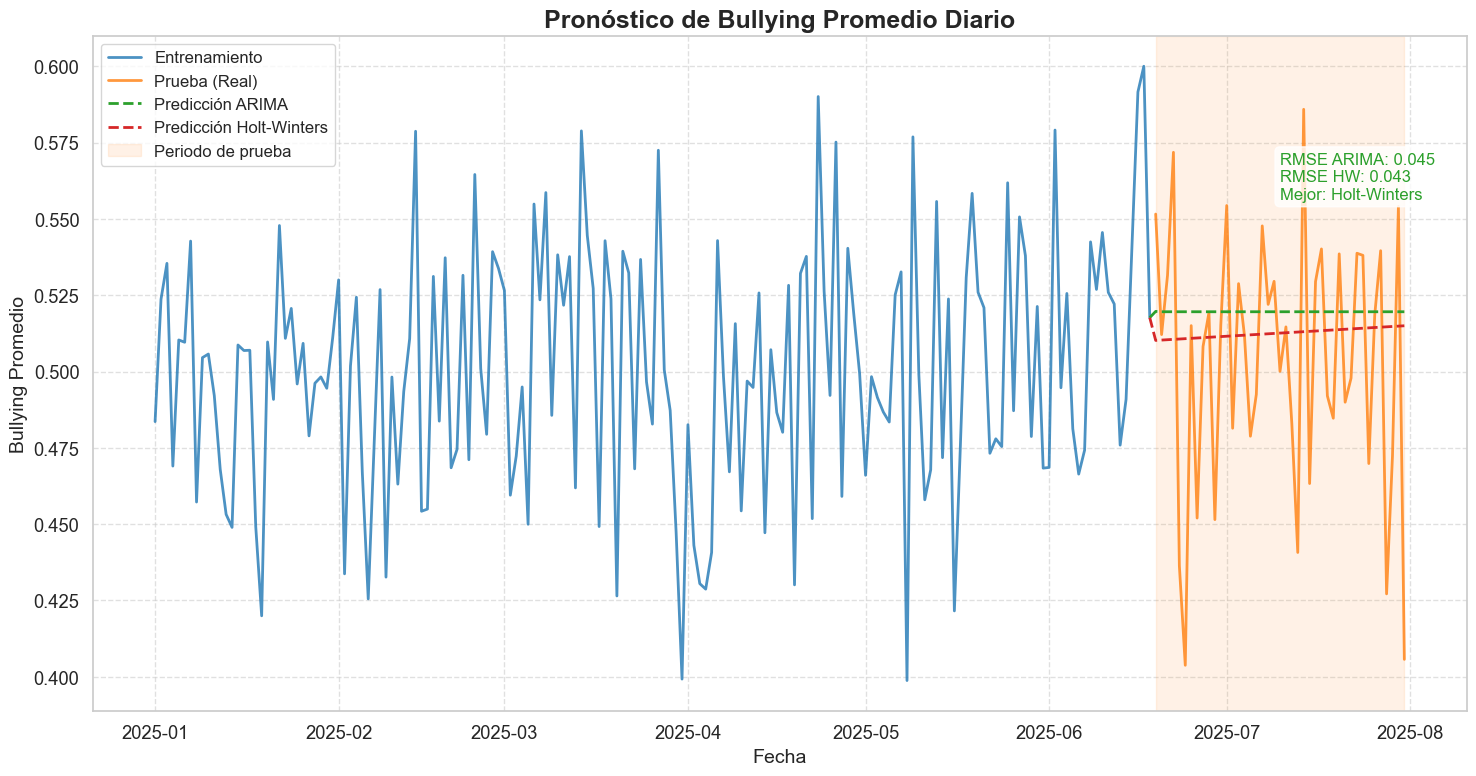


 ANÁLISIS ADICIONAL:

📊 ESTADÍSTICAS DE BULLYING:
   - Total de registros: 10000
   - Registros válidos: 10000
   - Valores faltantes: 0
   - Promedio general: 0.502
   - Mediana general: 0.506
   - Desviación estándar: 0.290
   - Mínimo: 0.000
   - Máximo: 1.000

�� TENDENCIA DE BULLYING:
   - Tendencia: Disminuyendo

 PREDICCIÓN DE BULLYING:
   - Próximos 43 días: 0.520 (ARIMA)
   - Próximos 43 días: 0.513 (Holt-Winters)

📅 ANÁLISIS POR DÍA DE LA SEMANA:
   - Lunes: 0.506 ± 0.287 (1367 registros)
   - Martes: 0.506 ± 0.289 (1416 registros)
   - Miércoles: 0.509 ± 0.292 (1483 registros)
   - Jueves: 0.494 ± 0.290 (1473 registros)
   - Viernes: 0.507 ± 0.290 (1456 registros)
   - Sábado: 0.497 ± 0.292 (1437 registros)
   - Domingo: 0.492 ± 0.288 (1368 registros)
   - Día con menos bullying: Domingo (0.492)
   - Día con más bullying: Miércoles (0.509)

⏰ ANÁLISIS POR HORA DEL DÍA:
   - 00:00: 0.477 (433.0 registros)
   - 01:00: 0.536 (418.0 registros)
   - 02:00: 0.486 (418.0 registros

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Calcular media diaria de bullying
print("🤖 Calculando media diaria de bullying...")

# Convertir bullying a numérico y manejar errores
ai_clean['bullying'] = pd.to_numeric(ai_clean['bullying'], errors='coerce')
bullying_diario = ai_clean.groupby(ai_clean['created_at'].dt.date)['bullying'].mean()
bullying_diario.index = pd.to_datetime(bullying_diario.index)
bullying_diario = bullying_diario.sort_index()

# Filtrar valores válidos
bullying_diario = bullying_diario.dropna()

print(f"   - Registros totales: {len(bullying_diario)} días")
print(f"   - Período: {bullying_diario.index.min()} a {bullying_diario.index.max()}")
print(f"   - Promedio diario: {bullying_diario.mean():.3f}")
print(f"   - Mediana diaria: {bullying_diario.median():.3f}")
print(f"   - Desviación estándar: {bullying_diario.std():.3f}")

# Separar train/test
split_idx = int(len(bullying_diario) * 0.8)
train, test = bullying_diario.iloc[:split_idx], bullying_diario.iloc[split_idx:]

print(f"   - Datos de entrenamiento: {len(train)} días")
print(f"   - Datos de prueba: {len(test)} días")

# ARIMA
print("🤖 Entrenando modelo ARIMA...")
arima_model = ARIMAModel(order=(1,1,1))
arima_model.fit(train)
arima_pred = arima_model.predict(len(test))
arima_pred.index = test.index

# Holt-Winters
print("📈 Entrenando modelo Holt-Winters...")
hw_model = HoltWintersModel(seasonal_periods=7, trend='add', seasonal=None)
hw_model.fit(train)
hw_pred = hw_model.predict(len(test))
hw_pred.index = test.index

# Métricas
from src.core.metrics import TimeSeriesMetrics
arima_metrics = TimeSeriesMetrics.calculate_forecast_accuracy(test, arima_pred)
hw_metrics = TimeSeriesMetrics.calculate_forecast_accuracy(test, hw_pred)

print("\n" + "="*50)
print("=== FORECASTING DE BULLYING PROMEDIO DIARIO ===")
print("="*50)

print("\n MÉTRICAS ARIMA:")
for k, v in arima_metrics.items():
    print(f"   {k.upper()}: {v:.3f}")

print("\n📈 MÉTRICAS HOLT-WINTERS:")
for k, v in hw_metrics.items():
    print(f"   {k.upper()}: {v:.3f}")

# Determinar mejor modelo
if arima_metrics['rmse'] < hw_metrics['rmse']:
    mejor_modelo = "ARIMA"
    mejor_rmse = arima_metrics['rmse']
else:
    mejor_modelo = "Holt-Winters"
    mejor_rmse = hw_metrics['rmse']

print(f"\n🏆 MEJOR MODELO: {mejor_modelo} (RMSE: {mejor_rmse:.3f})")

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

print("\n🎨 Generando visualización...")

# Concatenar el último valor real de entrenamiento con la predicción para continuidad visual
arima_pred_full = pd.concat([train[-1:], arima_pred])
arima_pred_full.index = train[-1:].index.append(arima_pred.index)

hw_pred_full = pd.concat([train[-1:], hw_pred])
hw_pred_full.index = train[-1:].index.append(hw_pred.index)

# Configurar estilo
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(15, 8))

# Plotear datos
plt.plot(train.index, train, label='Entrenamiento', color='#1f77b4', linewidth=2, alpha=0.8)
plt.plot(test.index, test, label='Prueba (Real)', color='#ff7f0e', linewidth=2, alpha=0.8)
plt.plot(arima_pred_full.index, arima_pred_full, label='Predicción ARIMA', color='#2ca02c', linestyle='--', linewidth=2)
plt.plot(hw_pred_full.index, hw_pred_full, label='Predicción Holt-Winters', color='#d62728', linestyle='--', linewidth=2)

# Área sombreada para el periodo de predicción (test)
plt.axvspan(test.index[0], test.index[-1], color='#ff7f0e', alpha=0.1, label='Periodo de prueba')

plt.title('Pronóstico de Bullying Promedio Diario', fontsize=18, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Bullying Promedio', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Anotar métricas en la gráfica
max_val = max(test.max(), arima_pred_full.max(), hw_pred_full.max())
plt.text(test.index[int(len(test)/2)], max_val * 0.95, 
         f"RMSE ARIMA: {arima_metrics['rmse']:.3f}\nRMSE HW: {hw_metrics['rmse']:.3f}\nMejor: {mejor_modelo}", 
         fontsize=12, color='#2ca02c', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

# Guardar gráfica
plt.savefig('bullying_forecasting.png', dpi=300, bbox_inches='tight')
print("💾 Gráfica guardada como 'bullying_forecasting.png'")

plt.show()

# Análisis adicional
print("\n ANÁLISIS ADICIONAL:")
print("="*30)

print(f"\n📊 ESTADÍSTICAS DE BULLYING:")
print(f"   - Total de registros: {len(ai_clean)}")
print(f"   - Registros válidos: {ai_clean['bullying'].notna().sum()}")
print(f"   - Valores faltantes: {ai_clean['bullying'].isna().sum()}")
print(f"   - Promedio general: {ai_clean['bullying'].mean():.3f}")
print(f"   - Mediana general: {ai_clean['bullying'].median():.3f}")
print(f"   - Desviación estándar: {ai_clean['bullying'].std():.3f}")
print(f"   - Mínimo: {ai_clean['bullying'].min():.3f}")
print(f"   - Máximo: {ai_clean['bullying'].max():.3f}")

print(f"\n�� TENDENCIA DE BULLYING:")
if bullying_diario.iloc[-10:].mean() > bullying_diario.iloc[:10].mean():
    print("   - Tendencia: Aumentando")
else:
    print("   - Tendencia: Disminuyendo")

print(f"\n PREDICCIÓN DE BULLYING:")
print(f"   - Próximos {len(test)} días: {arima_pred.mean():.3f} (ARIMA)")
print(f"   - Próximos {len(test)} días: {hw_pred.mean():.3f} (Holt-Winters)")

# Análisis de días de la semana
print(f"\n📅 ANÁLISIS POR DÍA DE LA SEMANA:")
ai_clean['day_of_week'] = ai_clean['created_at'].dt.dayofweek
bullying_por_dia = ai_clean.groupby('day_of_week')['bullying'].agg(['mean', 'count', 'std']).round(3)
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

for i, (dia, row) in enumerate(zip(dias, bullying_por_dia.itertuples())):
    print(f"   - {dia}: {row.mean:.3f} ± {row.std:.3f} ({row.count} registros)")

mejor_dia = dias[bullying_por_dia['mean'].idxmin()]  # Menor bullying es mejor
peor_dia = dias[bullying_por_dia['mean'].idxmax()]   # Mayor bullying es peor
print(f"   - Día con menos bullying: {mejor_dia} ({bullying_por_dia.loc[bullying_por_dia['mean'].idxmin(), 'mean']:.3f})")
print(f"   - Día con más bullying: {peor_dia} ({bullying_por_dia.loc[bullying_por_dia['mean'].idxmax(), 'mean']:.3f})")

# Análisis por hora del día
print(f"\n⏰ ANÁLISIS POR HORA DEL DÍA:")
if 'hour' in ai_clean.columns:
    bullying_por_hora = ai_clean.groupby('hour')['bullying'].agg(['mean', 'count']).round(3)
    
    for hora, row in bullying_por_hora.iterrows():
        print(f"   - {hora:02d}:00: {row['mean']:.3f} ({row['count']} registros)")
    
    mejor_hora = bullying_por_hora['mean'].idxmin()
    peor_hora = bullying_por_hora['mean'].idxmax()
    print(f"   - Hora con menos bullying: {mejor_hora:02d}:00 ({bullying_por_hora.loc[mejor_hora, 'mean']:.3f})")
    print(f"   - Hora con más bullying: {peor_hora:02d}:00 ({bullying_por_hora.loc[peor_hora, 'mean']:.3f})")

# Análisis de estudiantes
print(f"\n👨‍�� ANÁLISIS POR ESTUDIANTE:")
if 'sender_id' in ai_clean.columns:
    bullying_por_estudiante = ai_clean.groupby('sender_id')['bullying'].agg(['mean', 'count']).round(3)
    bullying_por_estudiante = bullying_por_estudiante.sort_values('mean', ascending=False)
    
    print(f"   - Top 5 estudiantes con mayor bullying:")
    for i, (estudiante, row) in enumerate(bullying_por_estudiante.head().iterrows()):
        print(f"     {i+1}. {estudiante}: {row['mean']:.3f} ({row['count']} mensajes)")
    
    print(f"   - Top 5 estudiantes con menor bullying:")
    for i, (estudiante, row) in enumerate(bullying_por_estudiante.tail().iterrows()):
        print(f"     {i+1}. {estudiante}: {row['mean']:.3f} ({row['count']} mensajes)")

# Análisis de tutores (CORREGIDO)
print(f"\n👨‍ ANÁLISIS POR TUTOR:")
if 'recipient_id' in ai_clean.columns:
    bullying_por_tutor = ai_clean.groupby('recipient_id')['bullying'].agg(['mean', 'count']).round(3)
    bullying_por_tutor = bullying_por_tutor.sort_values('mean', ascending=False)
    
    for tutor, row in bullying_por_tutor.iterrows():
        print(f"   - {tutor}: {row['mean']:.3f} ({row['count']} mensajes)")
    
    # CORRECCIÓN: Usar idxmin() y idxmax() directamente
    mejor_tutor = bullying_por_tutor['mean'].idxmin()
    peor_tutor = bullying_por_tutor['mean'].idxmax()
    print(f"   - Tutor con menos bullying: {mejor_tutor} ({bullying_por_tutor.loc[mejor_tutor, 'mean']:.3f})")
    print(f"   - Tutor con más bullying: {peor_tutor} ({bullying_por_tutor.loc[peor_tutor, 'mean']:.3f})")

# Análisis de correlación con otras variables
print(f"\n�� ANÁLISIS DE CORRELACIONES:")
if 'concern' in ai_clean.columns and 'academic_constructive' in ai_clean.columns:
    correlaciones = ai_clean[['bullying', 'concern', 'academic_constructive']].corr().round(3)
    
    print(f"   - Correlación Bullying-Concern: {correlaciones.loc['bullying', 'concern']:.3f}")
    print(f"   - Correlación Bullying-Academic: {correlaciones.loc['bullying', 'academic_constructive']:.3f}")
    print(f"   - Correlación Concern-Academic: {correlaciones.loc['concern', 'academic_constructive']:.3f}")
    
    if correlaciones.loc['bullying', 'concern'] > 0.5:
        print("   - ⚠️  Alta correlación entre bullying y preocupación")
    if correlaciones.loc['bullying', 'academic_constructive'] < -0.5:
        print("   - ✅ Alta correlación negativa entre bullying y comportamiento constructivo")

# Análisis de alertas
print(f"\n🚨 ANÁLISIS DE ALERTAS:")
umbral_alto = bullying_diario.quantile(0.9)
umbral_critico = bullying_diario.quantile(0.95)

dias_altos = bullying_diario[bullying_diario > umbral_alto]
dias_criticos = bullying_diario[bullying_diario > umbral_critico]

print(f"   - Umbral alto (90%): {umbral_alto:.3f}")
print(f"   - Umbral crítico (95%): {umbral_critico:.3f}")
print(f"   - Días con bullying alto: {len(dias_altos)} ({len(dias_altos)/len(bullying_diario)*100:.1f}%)")
print(f"   - Días con bullying crítico: {len(dias_criticos)} ({len(dias_criticos)/len(bullying_diario)*100:.1f}%)")

if len(dias_criticos) > 0:
    print(f"   - Último día crítico: {dias_criticos.index[-1].strftime('%Y-%m-%d')} ({dias_criticos.iloc[-1]:.3f})")